# Result wind state

In [1]:
#import warnings
#warnings.filterwarnings('ignore')
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = False

In [2]:
import pandas as pd
pd.set_option('display.max_rows', 5000)
pd.set_option('display.max_columns', 5000)
pd.set_option('display.width', 10000)
import numpy as np
import yaml

from vessel_manoeuvring_models.visualization.plot import track_plot, plot
from phd.visualization.plot_ship import track_plots
from vessel_manoeuvring_models.prime_system import PrimeSystem
from phd.visualization.plot_prediction import plot_total_force, plot_force_components, predict, plot_compare_model_forces, plot_parameter_contributions
from vessel_manoeuvring_models.symbols import *
import matplotlib.pyplot as plt
from vessel_manoeuvring_models.substitute_dynamic_symbols import run, lambdify, remove_functions, prime
from vessel_manoeuvring_models.parameters import df_parameters
p = df_parameters["symbol"]
import statsmodels.api as sm
import sympy as sp
from sympy import Eq, symbols, latex
import paper
from paper import save_fig, save_eq
import yaml
with open("styles.yml", mode='r') as file:
    styles = yaml.safe_load(file)

In [3]:
#%reload_kedro
ship='wPCC'
ship_data = catalog.load(f"{ship}.ship_data")

[01/31/24 13:33:18] INFO     Loading data from 'wPCC.ship_data' (YAMLDataSet)...                ]8;id=579604;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=640750;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

In [4]:
loaders = {
        
    'Reference model' : catalog.load(f"{ship}.models_VCT_MDL")['semiempirical_covered'],
    'Physics informed ID' : catalog.load(f"{ship}.models_ID_hull")['semiempirical_covered'],
    
    #'Abkowitz  VCT': catalog.load(f"{ship}.models_rudder_VCT_MDL")['Abkowitz'],
    'Abkowitz ID' : catalog.load(f"{ship}.models_ID_hull_rudder")['Abkowitz'],
}

                    WARNING  /home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/pa ]8;id=733103;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py\warnings.py]8;;\:]8;id=574992;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py#109\109]8;;\
                             rtitioned_dataset.py:200: KedroDeprecationWarning:                                    
                             'PartitionedDataset' has been moved to `kedro-datasets` and will be                   
                             removed in Kedro 0.19.0.                                                              
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  /home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/__ ]8;id=37798;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py\warnings.py]8;;\:]8;id=614773;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py#109\109]8;;\
                             init__.py:44: KedroDeprecationWarning: 'AbstractDataSet' has been                     
                             renamed to 'AbstractDataset', and the alias will be removed in Kedro                  
                             0.19.0                                                                                
                               return getattr(kedro.io.core, name)                                                 
                                                                                                                   

                    INFO     Loading data from 'wPCC.models_VCT_MDL' (PartitionedDataset)...    ]8;id=251283;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=351033;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

                    INFO     Loading data from 'wPCC.models_ID_hull' (PartitionedDataset)...    ]8;id=296356;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=444313;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

                    INFO     Loading data from 'wPCC.models_ID_hull_rudder'                     ]8;id=441984;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=538485;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\
                             (PartitionedDataset)...                                                               

In [5]:
models = {name:loader() for name,loader in loaders.items()}

In [6]:
model = models['Reference model']

## Idealized wind condition

In [7]:
N = 10
data = pd.DataFrame(index=np.arange(N))
data[model.states_str] = 0
data[model.control_keys] = 0
data['beta'] = np.deg2rad(np.linspace(-10,10,N))
data['V'] = 0.8
data['u'] = data['V']*np.cos(data['beta'])
data['v'] = -data['V']*np.sin(data['beta'])
data['thrust_port'] = 5
data['thrust_stbd'] = 5
data['thrust'] = data['thrust_port'] + data['thrust_stbd']

In [8]:
dataframes={}
for name, model_ in models.items():
    dataframes[name] = predict(model=model_, data=data)

[01/31/24 13:33:41] WARNING  /tmp/ipykernel_4788/2150284377.py:36: UserWarning: The figure layout   ]8;id=858081;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py\warnings.py]8;;\:]8;id=694192;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py#109\109]8;;\
                             has changed to tight                                                                  
                               plt.tight_layout()                                                                  
                                                                                                                   

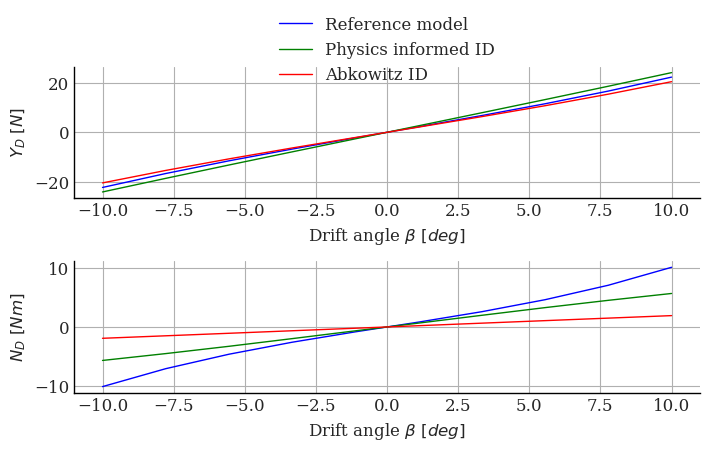

In [9]:

ylims={}
keys = ['Y_D','N_D']
units = ['N','Nm']
fig,axes=plt.subplots(nrows=len(keys))

for ax,y,unit in zip(axes,keys,units):

    for name,df in dataframes.items():
        df['beta_deg'] = np.rad2deg(df['beta'])
        df.plot(x='beta_deg', y=y, **styles[name], ax=ax)
    ax.set_xlabel(r'Drift angle $\beta$ $[deg]$')
    ax.set_ylabel(fr'${y}$ $[{unit}]$')
    
    if not unit in ylims:
        ylims[unit] = list(ax.get_ylim())
    else:
        ylims_ = ylims[unit]
        new_ylims = ax.get_ylim()
        if new_ylims[0] < ylims_[0]:
            ylims_[0] = new_ylims[0]
        
        if new_ylims[1] > ylims_[1]:
            ylims_[1] = new_ylims[1]
        

for ax,unit in zip(axes,units):
    ax.set_ylim(ylims[unit])    

for ax in axes:
    ax.grid()
    
for ax in axes[1:]:
    ax.get_legend().set_visible(False)
    
fig.axes[0].legend(loc='upper center', bbox_to_anchor=(0.5, 1.5), ncol=1)
plt.tight_layout()

In [10]:
fig.savefig(paper.file_path_with_nb_ref("forces.pdf"))

                    WARNING  /tmp/ipykernel_4788/3349348691.py:39: UserWarning: The figure layout   ]8;id=388596;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py\warnings.py]8;;\:]8;id=437515;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py#109\109]8;;\
                             has changed to tight                                                                  
                               plt.tight_layout()                                                                  
                                                                                                                   

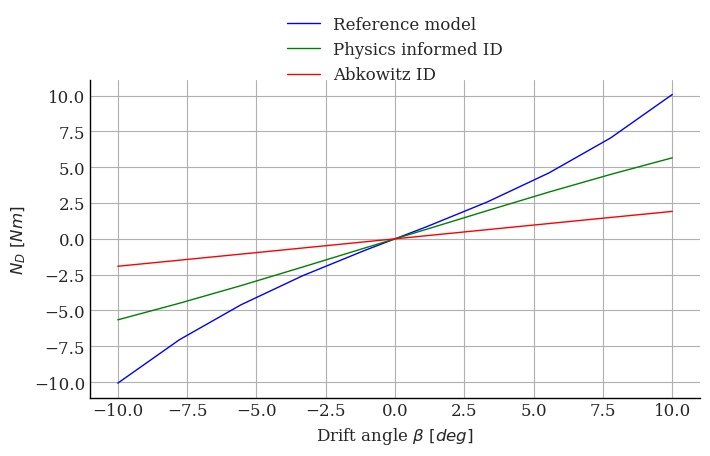

In [11]:

ylims={}
keys = ['N_D']
units = ['Nm']
fig,axes=plt.subplots(nrows=len(keys))

if len(keys)==1:
    axes=[axes]

for ax,y,unit in zip(axes,keys,units):

    for name,df in dataframes.items():
        df['beta_deg'] = np.rad2deg(df['beta'])
        df.plot(x='beta_deg', y=y, **styles[name], ax=ax)
    ax.set_xlabel(r'Drift angle $\beta$ $[deg]$')
    ax.set_ylabel(fr'${y}$ $[{unit}]$')
    
    if not unit in ylims:
        ylims[unit] = list(ax.get_ylim())
    else:
        ylims_ = ylims[unit]
        new_ylims = ax.get_ylim()
        if new_ylims[0] < ylims_[0]:
            ylims_[0] = new_ylims[0]
        
        if new_ylims[1] > ylims_[1]:
            ylims_[1] = new_ylims[1]
        

for ax,unit in zip(axes,units):
    ax.set_ylim(ylims[unit])    

for ax in axes:
    ax.grid()
    
for ax in axes[1:]:
    ax.get_legend().set_visible(False)
    
fig.axes[0].legend(loc='upper center', bbox_to_anchor=(0.5, 1.25), ncol=1)
plt.tight_layout()

fig.savefig(paper.file_path_with_nb_ref("forces.svg"))